# Answers to questions
What is the average human life expectancy in the world?<br /> 
How does this differ between low-, medium, and high-income countries? <br />
What characteristics of countries are predictors for differences in life expectancies? <br />
What characteristics are predictors for changes in life expectancy in a country over time?

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_raw = pd.read_csv('data/processed/merged_data.csv')
# rename columns for convenience
data_raw.rename(index=str, columns={'Life expectancy at birth (years)  Both sexes': 'LE_both'}, inplace=True)
data_raw.rename(index=str, columns={'Life expectancy at birth (years)  Male': 'LE_male'}, inplace=True)
data_raw.rename(index=str, columns={'Life expectancy at birth (years)  Female': 'LE_female'}, inplace=True)
data_raw.rename(columns={data_raw.columns[6]: 'GDP'}, inplace=True)
# Current health expenditure (CHE) per capita in US$
data_raw.rename(columns={data_raw.columns[7]: 'Health_expenditure'}, inplace=True)
# Research and development expenditure
data_raw.rename(columns={data_raw.columns[8]: 'RnD'}, inplace=True)
#
# basic cleansing
#
# South Sudan didn't exist before 2011
data_raw.drop(data_raw.loc[(data_raw['Country'] == 'South Sudan') & (data_raw['Year'] <= 2010)].index, inplace=True)

# setting income level correctly if we have GDP values
data_raw['Income Level'] = data_raw['Income Level'].replace(np.NaN, 'Unknown', inplace=False, regex=True)

incomplete_data = (data_raw[data_raw['Income Level'] == 'Unknown'])
incomplete_data.loc[:, 'Income Level'] = incomplete_data['Income Level'].mask(incomplete_data.GDP < 995, 'L')
incomplete_data.loc[:, 'Income Level'] = incomplete_data['Income Level'].mask(incomplete_data.GDP > 995, 'LM')

# we simply drop the remaining incomplete lines
data_raw['Income Level'] = data_raw['Income Level'].replace('Unknown', np.NaN, inplace=False, regex=True)
data_raw.dropna(subset=['Income Level'], inplace=True)

# finally copy data_raw to data which represents the cleansed data
data = data_raw.copy()

/usr/share/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


<strong>Side step</strong> checking correlation between GDP and income level 
show strong correlation between GDP and GNI before correction of Income Level "Unknown" based on GDP data; a value &gt; 0.7 means strong positive correlation

In [107]:
# checking and preparing data types of raw data
# as we have categorial data in Income level, we must set the correct data type
data_raw['Income Level'] = data_raw['Income Level'].astype('category')
# assign value to each category value - Index(['H', 'L', 'LM', 'UM', 'Unknown'], dtype='object')
print(data_raw['Income Level'].cat.categories)
data_raw['Income Level'].cat.categories = [4,1,2,3]
data_raw['Income Level'] = data_raw['Income Level'].astype(float)
print(data_raw.dtypes)

correlations = data_raw.corr()
print(correlations)

Float64Index([1.0, 2.0, 3.0, 4.0], dtype='float64')
Country                object
Year                    int64
LE_both               float64
LE_male               float64
LE_female             float64
Income Level          float64
GDP                   float64
Health_expenditure    float64
RnD                    object
dtype: object
                        Year   LE_both   LE_male  LE_female  Income Level  \
Year                1.000000  0.189338  0.197189   0.178376     -0.113777   
LE_both             0.189338  1.000000  0.992062   0.993650     -0.391250   
LE_male             0.197189  0.992062  1.000000   0.972308     -0.380759   
LE_female           0.178376  0.993650  0.972308   1.000000     -0.396104   
Income Level       -0.113777 -0.391250 -0.380759  -0.396104      1.000000   
GDP                 0.144854  0.588829  0.609264   0.561301     -0.346733   
Health_expenditure  0.146342  0.546184  0.561028   0.521055     -0.289049   

                         GDP  Health_expenditur

### 1. What is the average human life expectancy in the world?

In [78]:
print("The average life expectancy for both sexes is: {0}".format(data['LE_both'].mean()))
print("The average life expectancy for women is : {0}".format(data['LE_female'].mean()))
print("The average life expectancy for men is : {0}".format(data['LE_male'].mean()))

The average life expectancy for both sexes is: 69.20586319218235
The average life expectancy for women is : 71.57491856677521
The average life expectancy for men is : 66.86951140065143


### 2. How does this differ between low-, medium, and high-income countries? 

In [108]:
datagrouped = data.groupby(['Income Level'])
datagrouped['LE_both', 'LE_female', 'LE_male'].mean().sort_values(['LE_both'],ascending=False)

,LE_both,LE_female,LE_male
Income Level,,,
H,78.480728,80.987466,75.962803
UM,72.419625,75.444300,69.486147
LM,68.115169,70.597200,65.696616
L,58.698972,60.228278,57.158226


### 3. What characteristics of countries are predictors for differences in life expectancies?

In [128]:
from sklearn.decomposition import PCA

# cleansing for PCA
data_pca = data.copy()
data_pca = (data_pca[data_pca['Year'] == 2015])
data_pca.drop(columns=['Country', 'Year'], inplace=True)
# as we have categorial data in Income level, we must set the correct data type
data_pca['Income Level'] = data_pca['Income Level'].astype('category')
# assign value to each category value - Index(['H', 'L', 'LM', 'UM'], dtype='object')
data_pca['Income Level'].cat.categories = [4,1,2,3]
data_pca['Income Level'] = data_pca['Income Level'].astype(float)
data_pca.fillna(0, inplace=True)

pca = PCA(n_components=7)
pca.fit(data_pca)
#pca.components_

# Percentage of variance explained for each components
print('explained variance ratio: %s'
      % str(pca.explained_variance_ratio_))

df_pca = pd.DataFrame(pca.transform(data_pca), columns=data_pca.columns, index=data_pca.index)
df_pca.head()


explained variance ratio: [9.98567005e-01 1.43263823e-03 3.48448105e-07 5.86682948e-09
 1.40890312e-09 9.65952346e-10 6.12212108e-11]


,LE_both,LE_male,LE_female,Income Level,GDP,Health_expenditure,RnD
1,-11685.879408,121.871931,8.737111,-0.856072,-0.184462,0.624879,-0.074863
18,-8297.589473,30.678895,-12.093552,-1.341403,-0.282943,-0.347267,-0.032683
35,-8088.746461,38.123061,-12.008688,-2.813263,-0.179403,-0.475496,0.043765
52,-8579.617145,-102.445758,11.824887,0.785026,0.375103,-1.109025,0.052416
69,1405.712473,-429.319890,-5.447940,-0.134032,-0.078760,-1.044373,0.128809


                        Year   LE_both   LE_male  LE_female       GDP  \
Year                1.000000  0.189338  0.197189   0.178376  0.144854   
LE_both             0.189338  1.000000  0.992062   0.993650  0.588829   
LE_male             0.197189  0.992062  1.000000   0.972308  0.609264   
LE_female           0.178376  0.993650  0.972308   1.000000  0.561301   
GDP                 0.144854  0.588829  0.609264   0.561301  1.000000   
Health_expenditure  0.146342  0.546184  0.561028   0.521055  0.915376   

                    Health_expenditure  
Year                          0.146342  
LE_both                       0.546184  
LE_male                       0.561028  
LE_female                     0.521055  
GDP                           0.915376  
Health_expenditure            1.000000  


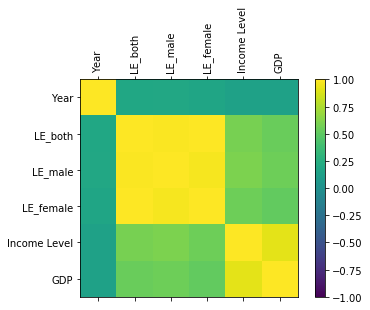

In [122]:
correlations = data.corr()
print(correlations)
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

As we can see this is not satisfactoring result, there is no strong correlation between GDP and life expectancy at birth. So let's look at a scatter plot and check if there is at least some linear relation between these variables.

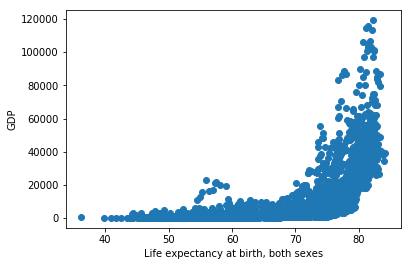

In [35]:
from pandas.plotting import scatter_matrix
#scatter_matrix(data)
#plt.show()
# show simple scatter plot
plt.ylabel('GDP')
plt.xlabel('Life expectancy at birth, both sexes')
plt.scatter(data["LE_both"], data["GDP"])

Next, we'll look at the correlation between 70 and older, maybe we can get better results.

                        Year   LE_both   LE_male  LE_female       GDP  \
Year                1.000000  0.176792  0.169786   0.170633  0.132430   
LE_both             0.176792  1.000000  0.962756   0.958128  0.731436   
LE_male             0.169786  0.962756  1.000000   0.846477  0.728348   
LE_female           0.170633  0.958128  0.846477   1.000000  0.679895   
GDP                 0.132430  0.731436  0.728348   0.679895  1.000000   
Health_expenditure  0.151750  0.747082  0.716340   0.713568  0.899209   

                    Health_expenditure  
Year                          0.151750  
LE_both                       0.747082  
LE_male                       0.716340  
LE_female                     0.713568  
GDP                           0.899209  
Health_expenditure            1.000000  


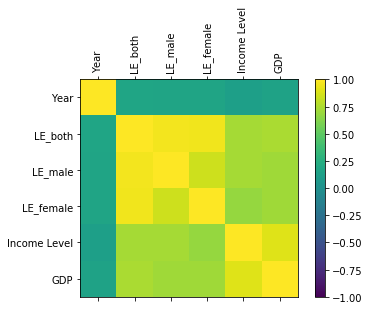

In [123]:
data_elderly = data[data.LE_both > 70]
correlations_elderly = data_elderly.corr()
print(correlations_elderly)
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations_elderly, vmin=-1, vmax=1)
fig.colorbar(cax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()